### critial_feature 
- '임대보증금', '임대료', '단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율','임대건물구분_lb', '공급유형_lb', '자격유형_lb', 'ERROR1_lb' (+'공가수', '지역')

In [21]:
import pandas as pd
import warnings 
import numpy as np
from matplotlib import rc, rcParams
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')
rc('font',family='AppleGothic')
rcParams['axes.unicode_minus']=False

In [44]:
path = './data_전용면적별/'

train = pd.read_csv(path+'train_new.csv')
test = pd.read_csv(path+'test_new.csv')

train_na = pd.read_csv('../data/2_train.csv')
test_na = pd.read_csv('../data/2_test.csv')

train.shape, test.shape, train_na.shape, test_na.shape

((1547, 70), (567, 68), (2952, 67), (1008, 66))

In [45]:
# train_na, test_na 전처리 

print(train_na[['임대보증금','임대료']].isnull().sum())
print(test_na[['임대보증금','임대료']].isnull().sum())

def create_new_X(old):
    # 전용면적의 소수점 없애기
    old['전용면적'] = old['전용면적'].apply(int)
    
    # 겹치는 전용면족 행 병합(결측치 없는 피처로 구분)
    cols = list(old.columns)
    cols.remove('전용면적별세대수')
    cols.remove('지하철')
    by_area = old.groupby(cols, as_index=False).agg({'전용면적별세대수': 'sum'})
    
    # 각 전용면적과 그에 상응하는 세대수의 곱
    by_area['면적_세대수_곱']  = by_area['전용면적'] * by_area['전용면적별세대수']
    
    # 각 단지코드당 계산된 실제 총 세대수
    by_area['면적_세대수_곱_총합'] = by_area['면적_세대수_곱'].groupby(by_area['단지코드']).transform('sum')
    
    # 비율 계산
    by_area['면적_세대수_비율'] = by_area['면적_세대수_곱']/by_area['면적_세대수_곱_총합']
    
    return by_area


def create_new_y(new_X):
    new_X['전용면적_비례_차량수'] = new_X.apply(lambda row: (row['면적_세대수_비율'] * row['등록차량수']), axis=1)
#     print(new_X[['단지코드','임대보증금','임대료']].isnull().sum())
    return new_X['전용면적_비례_차량수']


train_na.fillna(0, inplace=True)
test_na.fillna(0, inplace=True)
train_na_new = create_new_X(train_na)
test_na_new = create_new_X(test_na)

y_new = create_new_y(train_na_new)
train_na_new['전용면적_비례_차량수'] = y_new
train_na_new.info()


임대보증금    581
임대료      590
dtype: int64
임대보증금    186
임대료      186
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1504 entries, 0 to 1503
Data columns (total 70 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   단지코드         1504 non-null   object 
 1   총세대수         1504 non-null   int64  
 2   임대건물구분       1504 non-null   object 
 3   지역           1504 non-null   object 
 4   공급유형         1504 non-null   object 
 5   전용면적         1504 non-null   int64  
 6   공가수          1504 non-null   float64
 7   자격유형         1504 non-null   object 
 8   임대보증금        1504 non-null   float64
 9   임대료          1504 non-null   float64
 10  버스정류장        1504 non-null   float64
 11  단지내주차면수      1504 non-null   float64
 12  ERROR1       1504 non-null   object 
 13  임대건물구분_lb    1504 non-null   int64  
 14  상가           1504 non-null   int64  
 15  아파트          1504 non-null   int64  
 16  지역_lb        1504 non-null   int64  
 17  강원도         

array([[<AxesSubplot:title={'center':'임대보증금'}>,
        <AxesSubplot:title={'center':'임대료'}>,
        <AxesSubplot:title={'center':'단지내주차면수'}>],
       [<AxesSubplot:title={'center':'전용면적별세대수'}>,
        <AxesSubplot:title={'center':'면적_세대수_곱'}>,
        <AxesSubplot:title={'center':'면적_세대수_곱_총합'}>],
       [<AxesSubplot:title={'center':'면적_세대수_비율'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

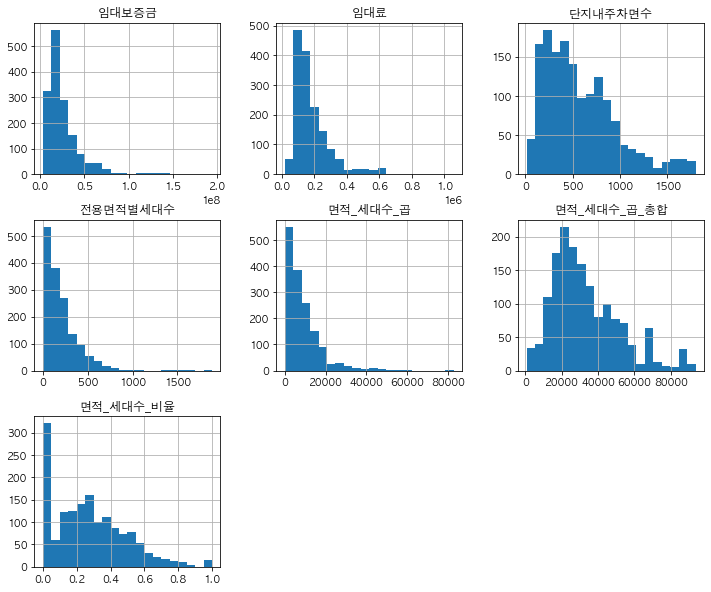

In [4]:
train[['임대보증금', '임대료', '단지내주차면수','전용면적별세대수',
       '면적_세대수_곱','면적_세대수_곱_총합', '면적_세대수_비율']].hist(figsize=(12,10), bins=20)


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score

In [6]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '공가수', '자격유형', '임대보증금',
       '임대료', '버스정류장', '단지내주차면수', 'ERROR1', '임대건물구분_lb', '상가', '아파트', '지역_lb',
       '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도',
       '공급유형_lb', '공공분양', '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)',
       '국민임대', '영구임대', '임대상가', '장기전세', '행복주택', '자격유형_lb', 'A', 'B', 'C', 'D',
       'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'ERROR1_lb',
       '나머지', '분양상가', '분양아파트', '등록차량수', '전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합',
       '면적_세대수_비율', '전용면적_비례_차량수'],
      dtype='object')

## no.1~4 

In [7]:
sel = ['임대보증금', '임대료', '단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율']
X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = StandardScaler()
X_nor = scaler.fit_transform(X)

# 모델 
lr = LinearRegression()
knn = KNeighborsRegressor()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()

# 회귀는 교차검증
lr_scores = cross_val_score(lr, X_nor, y,scoring='neg_mean_absolute_error', cv=5) 
knn_scores = cross_val_score(knn, X_nor, y,scoring='neg_mean_absolute_error', cv=5)
rf_scores = cross_val_score(rf, X_nor, y,scoring='neg_mean_absolute_error', cv=5)
dt_scores = cross_val_score(dt, X_nor, y,scoring='neg_mean_absolute_error', cv=5)

lr_score = np.abs(lr_scores.mean())
knn_score = np.abs(knn_scores.mean())
rf_score = np.abs(rf_scores.mean())
dt_score = np.abs(dt_scores.mean())

print("LinearRegression : ", lr_score)
print("KNeighborsRegressor : ", knn_score)
print("RandomForestRegressor : ", rf_score)
print("DecisionTreeRegressor : ", dt_score)

score_std = [lr_score, knn_score, rf_score, dt_score ]
print(score_std)

LinearRegression :  45.09672410199495
KNeighborsRegressor :  42.231211805615
RandomForestRegressor :  40.12493820436557
DecisionTreeRegressor :  52.28150662314331
[45.09672410199495, 42.231211805615, 40.12493820436557, 52.28150662314331]


## no.5~8

In [8]:
sel = ['임대보증금', '임대료', '단지내주차면수','전용면적별세대수','면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율']

X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = MinMaxScaler()
X_nor = scaler.fit_transform(X)

# 모델 
lr = LinearRegression()
knn = KNeighborsRegressor()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()

# 회귀는 교차검증
lr_scores = cross_val_score(lr, X_nor, y,scoring='neg_mean_absolute_error', cv=5) 
knn_scores = cross_val_score(knn, X_nor, y,scoring='neg_mean_absolute_error', cv=5)
rf_scores = cross_val_score(rf, X_nor, y,scoring='neg_mean_absolute_error', cv=5)
dt_scores = cross_val_score(dt, X_nor, y,scoring='neg_mean_absolute_error', cv=5)

lr_score = np.abs(lr_scores.mean())
knn_score = np.abs(knn_scores.mean())
rf_score = np.abs(rf_scores.mean())
dt_score = np.abs(dt_scores.mean())

print("LinearRegression : ", lr_score)
print("KNeighborsRegressor : ", knn_score)
print("RandomForestRegressor : ", rf_score)
print("DecisionTreeRegressor : ", dt_score)

score_std = [lr_score, knn_score, rf_score, dt_score ]
print(score_std)

LinearRegression :  45.09672410199497
KNeighborsRegressor :  41.93992855711986
RandomForestRegressor :  40.20553324743634
DecisionTreeRegressor :  52.97470770492034
[45.09672410199497, 41.93992855711986, 40.20553324743634, 52.97470770492034]


## no. 9~12

In [49]:
sel = ['임대보증금', '임대료', '단지내주차면수','전용면적별세대수','면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율']

X = train_na_new[sel]
y = train_na_new[['전용면적_비례_차량수']]

# 피처스케일링
scaler = StandardScaler()
X_nor = scaler.fit_transform(X)

# 모델 
lr = LinearRegression()
knn = KNeighborsRegressor()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()

# 회귀는 교차검증
lr_scores = cross_val_score(lr, X_nor, y,scoring='neg_mean_absolute_error', cv=5) 
knn_scores = cross_val_score(knn, X_nor, y,scoring='neg_mean_absolute_error', cv=5)
rf_scores = cross_val_score(rf, X_nor, y,scoring='neg_mean_absolute_error', cv=5)
dt_scores = cross_val_score(dt, X_nor, y,scoring='neg_mean_absolute_error', cv=5)

lr_score = np.abs(lr_scores.mean())
knn_score = np.abs(knn_scores.mean())
rf_score = np.abs(rf_scores.mean())
dt_score = np.abs(dt_scores.mean())

print("LinearRegression : ", lr_score)
print("KNeighborsRegressor : ", knn_score)
print("RandomForestRegressor : ", rf_score)
print("DecisionTreeRegressor : ", dt_score)

score_std = [lr_score, knn_score, rf_score, dt_score ]
print(score_std)

LinearRegression :  44.87972013859171
KNeighborsRegressor :  44.32160515044741
RandomForestRegressor :  41.94135787677359
DecisionTreeRegressor :  54.31105542334994
[44.87972013859171, 44.32160515044741, 41.94135787677359, 54.31105542334994]


## no.13

In [51]:
sel = ['단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율']
X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = StandardScaler()
X_nor = scaler.fit_transform(X)

# 모델 
rf = RandomForestRegressor()

# 회귀는 교차검증
rf_scores = cross_val_score(rf, X_nor, y,scoring='neg_mean_absolute_error', cv=5)

rf_score = np.abs(rf_scores.mean())
print("RandomForestRegressor : ", rf_score)

RandomForestRegressor :  41.5891637148224


## no. 14~16

In [57]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge


sel = ['단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율']
X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = StandardScaler()# MinMaxScaler StandardScaler
X_nor = scaler.fit_transform(X)
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_nor)  

# 모델 
rf = RandomForestRegressor()

# 회귀는 교차검증
rf_scores = cross_val_score(rf, X_poly, y,scoring='neg_mean_absolute_error', cv=5)

rf_score = np.abs(rf_scores.mean())
print("RandomForestRegressor : ", rf_score)

# Ridge, Lasso
lasso = Lasso()
ridge = Ridge()
lasso_scores = cross_val_score(lasso, X_poly, y,scoring='neg_mean_absolute_error', cv=5)
ridge_scores = cross_val_score(ridge, X_poly, y,scoring='neg_mean_absolute_error', cv=5)

lasso_score = np.abs(lasso_scores.mean())
ridge_score = np.abs(ridge_scores.mean())

print("Lasso (alpha=defalt) : ", lasso_score)
print("Ridge (alpha=defalt) : ", ridge_score)

RandomForestRegressor :  40.09149580735395
Lasso (alpha=defalt) :  36.18282477251343
Ridge (alpha=defalt) :  36.138897953825136


## no.17~19

In [55]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge


sel = ['임대보증금','임대료','단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율']
X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = StandardScaler()
X_nor = scaler.fit_transform(X)
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_nor)  

# 모델 
rf = RandomForestRegressor()

# 회귀는 교차검증
rf_scores = cross_val_score(rf, X_poly, y,scoring='neg_mean_absolute_error', cv=5)

rf_score = np.abs(rf_scores.mean())
print("RandomForestRegressor : ", rf_score)

# Ridge, Lasso
lasso = Lasso()
ridge = Ridge()
lasso_scores = cross_val_score(lasso, X_poly, y,scoring='neg_mean_absolute_error', cv=5)
ridge_scores = cross_val_score(ridge, X_poly, y,scoring='neg_mean_absolute_error', cv=5)

lasso_score = np.abs(lasso_scores.mean())
ridge_score = np.abs(ridge_scores.mean())

print("Lasso (alpha=defalt) : ", lasso_score)
print("Ridge (alpha=defalt) : ", ridge_score)

RandomForestRegressor :  38.80820038200775
Lasso (alpha=defalt) :  37.236664794834326
Ridge (alpha=defalt) :  38.27780198193362


## no.20~22

In [60]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge


sel = ['단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율']
X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = MinMaxScaler()# MinMaxScaler StandardScaler
X_nor = scaler.fit_transform(X)
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_nor)  

# 모델 
rf = RandomForestRegressor()

# 회귀는 교차검증
rf_scores = cross_val_score(rf, X_poly, y,scoring='neg_mean_absolute_error', cv=5)

rf_score = np.abs(rf_scores.mean())
print("RandomForestRegressor : ", rf_score)

# Ridge, Lasso
lasso = Lasso()
ridge = Ridge()
lasso_scores = cross_val_score(lasso, X_poly, y,scoring='neg_mean_absolute_error', cv=5)
ridge_scores = cross_val_score(ridge, X_poly, y,scoring='neg_mean_absolute_error', cv=5)

lasso_score = np.abs(lasso_scores.mean())
ridge_score = np.abs(ridge_scores.mean())

print("Lasso (alpha=defalt) : ", lasso_score)
print("Ridge (alpha=defalt) : ", ridge_score)


RandomForestRegressor :  35.79800631079669
Lasso (alpha=defalt) :  38.880021927895335
Ridge (alpha=defalt) :  37.67362108231964


## no.23~24

In [70]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge


sel = ['임대료','단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율']
X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = MinMaxScaler()# MinMaxScaler StandardScaler
X_nor = scaler.fit_transform(X)
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_nor)  

# 모델 
rf = RandomForestRegressor()

# 회귀는 교차검증
rf_scores = cross_val_score(rf, X_poly, y,scoring='neg_mean_absolute_error', cv=5)

rf_score = np.abs(rf_scores.mean())
print("RandomForestRegressor : ", rf_score)

# Ridge, Lasso
lasso = Lasso()
ridge = Ridge()
lasso_scores = cross_val_score(lasso, X_poly, y,scoring='neg_mean_absolute_error', cv=5)
ridge_scores = cross_val_score(ridge, X_poly, y,scoring='neg_mean_absolute_error', cv=5)

lasso_score = np.abs(lasso_scores.mean())
ridge_score = np.abs(ridge_scores.mean())

print("Lasso (alpha=defalt) : ", lasso_score)
print("Ridge (alpha=defalt) : ", ridge_score)


RandomForestRegressor :  35.559953812571145
Lasso (alpha=defalt) :  38.57457931506346
Ridge (alpha=defalt) :  38.13982205532718


In [68]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge


sel = ['임대료','단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율']
X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = StandardScaler()# MinMaxScaler StandardScaler
X_nor = scaler.fit_transform(X)
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_nor)  

# 모델 
rf = RandomForestRegressor()

# 회귀는 교차검증
rf_scores = cross_val_score(rf, X_poly, y,scoring='neg_mean_absolute_error', cv=5)

rf_score = np.abs(rf_scores.mean())
print("RandomForestRegressor : ", rf_score)

# Ridge, Lasso
lasso = Lasso()
ridge = Ridge()
lasso_scores = cross_val_score(lasso, X_poly, y,scoring='neg_mean_absolute_error', cv=5)
ridge_scores = cross_val_score(ridge, X_poly, y,scoring='neg_mean_absolute_error', cv=5)

lasso_score = np.abs(lasso_scores.mean())
ridge_score = np.abs(ridge_scores.mean())

print("Lasso (alpha=defalt) : ", lasso_score)
print("Ridge (alpha=defalt) : ", ridge_score)


RandomForestRegressor :  39.058472154926456
Lasso (alpha=defalt) :  37.11119741246477
Ridge (alpha=defalt) :  37.2684074624868


## no.25

In [71]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge


sel = ['임대료','단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율',
      '상가','아파트']

X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = MinMaxScaler()# MinMaxScaler StandardScaler
X_nor = scaler.fit_transform(X)
tmp_X_nor = X_nor[:,:6]
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(tmp_X_nor)  

X_all = np.concatenate((X_poly, X_nor[:,6:]), axis=1)

# 모델 
rf = RandomForestRegressor()

# 회귀는 교차검증
rf_scores = cross_val_score(rf, X_all, y,scoring='neg_mean_absolute_error', cv=5)

rf_score = np.abs(rf_scores.mean())
print("RandomForestRegressor : ", rf_score)

# Ridge, Lasso
lasso = Lasso()
ridge = Ridge()
lasso_scores = cross_val_score(lasso, X_all, y,scoring='neg_mean_absolute_error', cv=5)
ridge_scores = cross_val_score(ridge, X_all, y,scoring='neg_mean_absolute_error', cv=5)

lasso_score = np.abs(lasso_scores.mean())
ridge_score = np.abs(ridge_scores.mean())

print("Lasso (alpha=defalt) : ", lasso_score)
print("Ridge (alpha=defalt) : ", ridge_score)


RandomForestRegressor :  35.305212359441036
Lasso (alpha=defalt) :  38.57392958177389
Ridge (alpha=defalt) :  37.90325673070581


## no. 26

In [73]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge


sel = ['임대료','단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율',
      '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도']

X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = MinMaxScaler()# MinMaxScaler StandardScaler
X_nor = scaler.fit_transform(X)
tmp_X_nor = X_nor[:,:6]
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(tmp_X_nor)  

X_all = np.concatenate((X_poly, X_nor[:,6:]), axis=1)

# 모델 
rf = RandomForestRegressor()

# 회귀는 교차검증
rf_scores = cross_val_score(rf, X_all, y,scoring='neg_mean_absolute_error', cv=5)
rf_score = np.abs(rf_scores.mean())
print("RandomForestRegressor : ", rf_score)


RandomForestRegressor :  34.448468120960065


## no. 27

In [75]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge


sel = ['임대료','단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율',
      '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도',
      '공공분양', '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)',
       '국민임대', '영구임대', '임대상가', '장기전세', '행복주택']

X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = MinMaxScaler()# MinMaxScaler StandardScaler
X_nor = scaler.fit_transform(X)
tmp_X_nor = X_nor[:,:6]
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(tmp_X_nor)  

X_all = np.concatenate((X_poly, X_nor[:,6:]), axis=1)

# 모델 
rf = RandomForestRegressor()

# 회귀는 교차검증
rf_scores = cross_val_score(rf, X_all, y,scoring='neg_mean_absolute_error', cv=5)
rf_score = np.abs(rf_scores.mean())
print("RandomForestRegressor : ", rf_score)


RandomForestRegressor :  34.46394656760762


## no.28

In [76]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge


sel = ['임대료','단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율',
      '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도',
      'A', 'B', 'C', 'D','E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O'
      ]

X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = MinMaxScaler()# MinMaxScaler StandardScaler
X_nor = scaler.fit_transform(X)
tmp_X_nor = X_nor[:,:6]
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(tmp_X_nor)  

X_all = np.concatenate((X_poly, X_nor[:,6:]), axis=1)

# 모델 
rf = RandomForestRegressor()

# 회귀는 교차검증
rf_scores = cross_val_score(rf, X_all, y,scoring='neg_mean_absolute_error', cv=5)
rf_score = np.abs(rf_scores.mean())
print("RandomForestRegressor : ", rf_score)


RandomForestRegressor :  34.53431016442851


## no.29

In [77]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge


sel = ['임대료','단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율',
      '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도',
      '나머지', '분양상가', '분양아파트']

X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = MinMaxScaler()# MinMaxScaler StandardScaler
X_nor = scaler.fit_transform(X)
tmp_X_nor = X_nor[:,:6]
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(tmp_X_nor)  

X_all = np.concatenate((X_poly, X_nor[:,6:]), axis=1)

# 모델 
rf = RandomForestRegressor()

# 회귀는 교차검증
rf_scores = cross_val_score(rf, X_all, y,scoring='neg_mean_absolute_error', cv=5)
rf_score = np.abs(rf_scores.mean())
print("RandomForestRegressor : ", rf_score)


RandomForestRegressor :  34.306262789324094


## no. 30
### xgboost

In [78]:
import xgboost as xgb
import lightgbm as lgb
import time

In [79]:
sel = ['임대료','단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율',
      '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도',
      '나머지', '분양상가', '분양아파트']

X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = MinMaxScaler()# MinMaxScaler StandardScaler
X_nor = scaler.fit_transform(X)
tmp_X_nor = X_nor[:,:6]
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(tmp_X_nor)  

X_all = np.concatenate((X_poly, X_nor[:,6:]), axis=1)


# xgboost
data_dmatrix = xgb.DMatrix(data=X_all,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
            colsample_bytree = 0.3, # 각나무마다 사용하는 feature 비율
            learning_rate = 0.1,
            max_depth = 3, 
            alpha = 0.1, 
            n_estimators = 100)  # n_estimators=100

xg_reg.fit(X_all, y)
score = cross_val_score(xg_reg, X_all, y, cv=5, scoring="neg_mean_absolute_error")
m_score = np.abs(score.mean())  
print("Xgboost : {}".format(m_score)) 

[00:38:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c09

## no. 31
### lightgbm

In [84]:
sel = ['임대료','단지내주차면수','전용면적별세대수', '면적_세대수_곱', '면적_세대수_곱_총합','면적_세대수_비율',
      '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도',
      '나머지', '분양상가', '분양아파트']

X = train[sel]
y = train[['전용면적_비례_차량수']]

# 피처스케일링
scaler = MinMaxScaler()# MinMaxScaler StandardScaler
X_nor = scaler.fit_transform(X)
tmp_X_nor = X_nor[:,:6]
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(tmp_X_nor)  

X_all = np.concatenate((X_poly, X_nor[:,6:]), axis=1)

m_lgbm1 = lgb.LGBMRegressor()
m_lgbm1.fit(X_all, y)
score = cross_val_score(m_lgbm1, X_all, y, 
                        cv=5, scoring="neg_mean_absolute_error")

m_score = np.abs(score.mean())  # 절대값

print("LightGBM Score : {}".format(m_score))  # 점수

LightGBM Score : 37.63034153935594


DescribeResult(nobs=567, minmax=(3.709184390744469, 950.6329414189755), mean=144.07594474433188, variance=22639.064189523026, skewness=1.9659943921554013, kurtosis=5.424727771545223)


(array([185.,  80.,  83.,  74.,  38.,  33.,  15.,  13.,  21.,   4.,   4.,
          6.,   1.,   1.,   2.,   2.,   1.,   1.,   1.,   2.]),
 array([  3.70918439,  51.05537224,  98.40156009, 145.74774794,
        193.0939358 , 240.44012365, 287.7863115 , 335.13249935,
        382.4786872 , 429.82487505, 477.1710629 , 524.51725076,
        571.86343861, 619.20962646, 666.55581431, 713.90200216,
        761.24819001, 808.59437786, 855.94056572, 903.28675357,
        950.63294142]),
 <BarContainer object of 20 artists>)

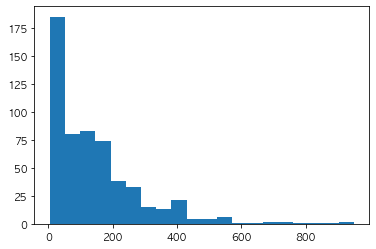

In [10]:
from scipy import stats

X_test = test[sel]
X_test_nor = scaler.transform(X_test)

rf.fit(X_nor, y)
pred = rf.predict(X_test_nor)
print(stats.describe(pred))
plt.hist(pred, bins=20)